# ForceSMIP Minimal Example: Multiple Linear Regression

By: Stephen Po-Chedley (inspired by [Foster and Rahmstorf, 2011](https://iopscience.iop.org/article/10.1088/1748-9326/6/4/044022))

Suggestions and Improvements Welcome!

The goal of this notebook is to demonstrate the use of multiple linear regression to estimate the contributions of internal variability and various forcing agents to surface temperature variability and change. The notebook works with Tier 1 Data and `tas`, but modifications may be necessary to analyze other ForceSMIP data.

In this example we will use forcing time series (GHG, aerosol, volcanic, and solar) and an ENSO index (surface temperature in the Ni$\mathrm{\widetilde{n}}$o 3.4 region) as predictors. These five time series populate our predictor matrix, **X**, which will be of shape [nt, 5] (where nt is the number of timesteps). Our predictand matrix, **Y**, will be either the global mean surface temperature time series or the 3D time series of surface temperature (time, lat, lon), such that:

**Y** = $\alpha$ * T$_{ENSO}$ + $\beta$ * F$_{solar}$ + $\Gamma$ * F$_{volcanic}$ + $\delta$ * F$_{aerosols}$ + $\epsilon$ * F$_{GHG}$ + C

where $\alpha$, $\beta$, $\Gamma$, $\delta$, and $\epsilon$ are the linear coefficients and C is a constant offset. **Y** is either a matrix of length nt or of shape [nt, nlat $\cdot$ nlon].

In this notebook, we use [sklearn's LinearRegression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), but many packages are available to do this kind of calculation (with slightly different syntax). 

#### Outline:

* Setup and Options
    * Notes on setup with conda
    * Import of key packages
    * Setting some user-specified options
* Process Predictor Data
    * Load and inspect the forcing time series (and ensure it matches the time period of interest)
* Apply Multiple Linear Regression to one model
    * Create a function to read in model data including an ENSO index, global mean surface temperature, and the 3D field
    * Load data from one model ensemble
    * Create **X** and **Y** matrices and apply multiple linear regression to the global mean temperature for one realization
    * Plot output from regression model (compared to actual model time series)
    * Fit regression model to all model ensemble members
    * Compare the estimated forced response to the actual, ensemble mean forced response
    * Calculate and plot the predicted-versus-actual unforced global mean temperature trends
    * Extend regression model to 3D (time, lat, lon) data
    * Plot predicted forced/unforced anomaly map for El Ni$\mathrm{\widetilde{n}}$o and La Ni$\mathrm{\widetilde{n}}$a years
    * Plot the coefficient maps for the regression model
* Apply Multiple Linear Regression to Training / Evaluation Data
    * Create a function to apply multiple linear regression to either a global mean time series or a 3D (time, lat, lon) time series
    * Iteratively apply multiple linear regression model to all models / members in training dataset 
    * Plot the predicted-versus-actual forced and unforced global mean temperature time series
    * Plot the predicted-versus-actual forced trend maps
    * Apply regression model to evaluation data (and plot forced trend map)
* Discussion Questions

## Some setup notes

If you are using Jupyter (or Python with conda environments), there may be a `forcesmip` kernel/environment pre-installed for you to use. You can also check by clicking `Kernel` > `Change Kernel...` (and then look for a `forcesmip` kernel). You can determine if a conda environment exists by looking for it with `conda info --envs` in a terminal. If you use a pre-installed kernel, you can simply use the pre-installed `forcesmip` kernel and you do not need to continue with this setup.

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)). On some systems you may need to load or activate conda (e.g., via `module load conda` on NCAR systems). Once conda is installed and active, you can create a forcesmip environment with (the `-y` flag says to go ahead and create the environment without a prompt): 

`conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel tensorflow python=3.9 -y`

This may take a long time (i.e., hours!). If you're in a rush and are not using neural networks, you can remove `tensorflow` from `conda install` and install it afterwards with `pip install tensorflow` (if desired). 

Activate your environment with: `conda activate forcesmip` or `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages

In [1]:
# Imports

# Data wrangling / IO
import glob
import xcdat as xc
import pandas
import numpy as np
import re
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# linear regression
from sklearn.linear_model import LinearRegression

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [2]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### User options

Set some options on data location, variable of interest, analysis period, etc.

In [3]:
# User parameters
# root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # path to forcesmip data (ETH)
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

fn_forcing = "https://raw.githubusercontent.com/IPCC-WG1/Chapter-7/main/data_output/AR6_ERF_1750-2019.csv"  # this is the forcing data we'll use as a predictor
ncvar = "tas"  # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)
model = 'MIROC6'  # model to illustrate methodology with training data

# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3
tv_time_period = evalPeriods[eval_tier]  # populates based on the evaluation data tier, but can be overwritten (with a tuple of date strings)

### Get the forcing data

We download the forcing data and sum up the components into broad categories: GHGs, aerosols, solar, and volcanic. Since the data ends in 2019, we'll do a very simple extrapolation through 2022 to conform with the ForceSMIP data.

> Note that GHGs isn't strictly greenhouse gases, but this is the bulk of the forcing term. Land-use is included, but it is small and relatively linear. 

In [4]:
# Wrangle predictor (forcing) time series
predictor_data = {}
df = pandas.read_csv(fn_forcing)
predictor_data['ghg'] = df['co2'] + df['ch4'] + df['n2o'] + df['other_wmghg'] + df['o3'] + df['h2o_stratospheric'] + df['land_use']
predictor_data['aerosols'] = df['aerosol-radiation_interactions'] + df['aerosol-cloud_interactions'] + df['contrails'] + df['bc_on_snow']
predictor_data['solar'] = df['solar']
predictor_data['volcanic'] = df['volcanic']
predictor_data['year'] = df['year']

# extend data by three years through 2022 (simple extrapolation)
for key in predictor_data.keys():
    # get predictor time series
    ts = np.array(predictor_data[key])
    # calculate difference between last two points
    delta = ts[-1] - ts[-2]
    # assume the forcing changes by this increment in next 3 time steps
    ts_extend = np.array([ts[-1] + delta, ts[-1] + delta*2, ts[-1] + delta*3])
    # concatenate the extrapolated values to the time series
    ts = np.concatenate((ts, ts_extend))
    # store data
    predictor_data[key] = ts

### Plot the forcing time series

Plot of the full forcing time series (we will have to select the correct time period since it begins in 1750).

Text(0, 0.5, 'Forcing [W m$^{-1}$]')

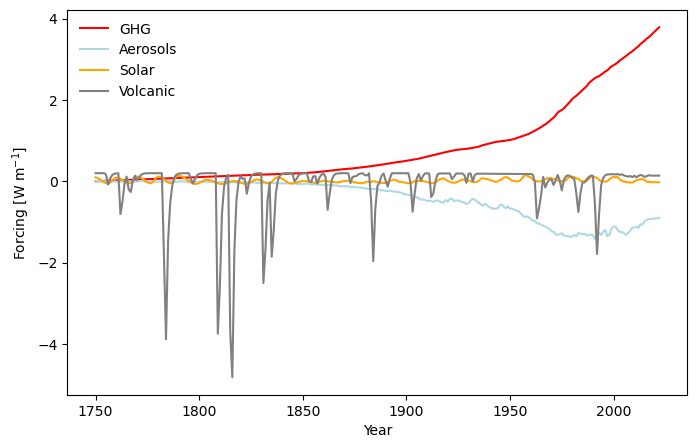

In [5]:
# plot predictor data
plt.figure(figsize=(8, 5))
plt.plot(predictor_data['year'], predictor_data['ghg'], 'r', label='GHG')
plt.plot(predictor_data['year'], predictor_data['aerosols'], 'lightblue', label='Aerosols')
plt.plot(predictor_data['year'], predictor_data['solar'], 'orange', label='Solar')
plt.plot(predictor_data['year'], predictor_data['volcanic'] , 'gray', label='Volcanic')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Year')
plt.ylabel('Forcing [W m$^{-1}$]')

### Subset forcing data

Subset the forcing time period to match the user-defined train/validation time period.

In [6]:
## Subset forcing data to train/validation time period
# get start/end year from user-options
syear = int(tv_time_period[0].split('-')[0])
eyear = int(tv_time_period[1].split('-')[0])
years = predictor_data['year']
# find indices of forcing data that match user-specified time range
inds = np.where((years >= syear) & (years <= eyear))[0]
# loop over variables and subset forcing time series
for key in predictor_data.keys():
    ts = predictor_data[key]
    predictor_data[key] = ts[inds]

### Define a function to read in data

We're going to loop over many model realizations to load training/evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation. Note that the data returned is annual averages (because our input forcing time series are annually-resolved), but ForceSMIP protocol requests monthly data.

In [7]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the annual anomalies
    relative to a user-defined reference_period. The function returns arrays
    of the 3D anomaly map, and the global mean time series, and the spatial
    average time series in the Nino 3.4 region. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : global mean anomaly values
    ts_e (xr.DataArray) : ENSO anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    # grab attributes - these are getting dropped in a recent xarray version
    # https://github.com/xCDAT/xcdat/issues/529
    lat_attrs = ds.lat.attrs
    lon_attrs = ds.lon.attrs
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # get annual averages
    ds = ds.temporal.group_average(vid, freq='year')
    # add attributes that are dropped
    ds.lat.attrs = lat_attrs
    ds.lon.attrs = lon_attrs
    ts_3d = ds[vid]
    # get ENSO index
    dse = ds.spatial.average(vid, lat_bounds=(-5, 5), lon_bounds=(190, 240))
    ts_e = dse[vid]
    # take global average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    dse.close()
    # return values
    return ts_3d, ts_gm, ts_e

### Get data for one model ensemble

Here we load in the time series for all members of one model. This will allow us to illustrate the method for one model (before applying it to other models). We store data in a nested dictionary (with the model and member names as keys). 

In [8]:
# get model data path
mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
# get model files
mfiles = glob.glob(mpath + '/*.nc')
# parse file names for model variant labels
if model == "CESM2":
    members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
else:
    members = [p.split("_")[-1].split(".")[0] for p in mfiles]
members = sorted(members, key=natsort)
# the file / path variable id can differ - this is the variable id in the file
vid = cmipVar[ncvar]

# initialize dictionaries to store data
global_mean_timeseries = {model: {}}
enso_time_series = {model: {}}
anomaly_maps = {model: {}}
# loop over members to load data
for i, member in enumerate(members):
    # search for file corresponding to model member
    fn = glob.glob(mpath + "/*_" + member + ".*.nc")
    # make sure filename is unique
    if len(fn) != 1:
        raise ValueError("Unexpected number of model members")
    else:
        fn = fn[0]
    print('.', end='')
    # load data
    ts_3d, ts_gm, ts_e = load_realization(fn, vid, tv_time_period, reference_period)
    # store data in dictionaries
    global_mean_timeseries[model][member] = ts_gm
    enso_time_series[model][member] = ts_e
    anomaly_maps[model][member] = ts_3d
print()

..................................................


### Build X / Y matrices to predict the components of mean temperature change

In [9]:
# construct a predictor matrix for the first member
member = members[0]

# predictor matrix is [nt, zn] where zn denotes the number of predictor time series (zn=5):
# ENSO, Solar, Volcanic, Aerosols, GHG
nt = len(global_mean_timeseries[model][member])  # timeseries length
X = np.zeros((nt, 5))  # pre-allocate predictor matrix
# add values to predictor matrix
X[:, 0] = enso_time_series[model][member]
X[:, 1] = predictor_data['solar']
X[:, 2] = predictor_data['volcanic']
X[:, 3] = predictor_data['aerosols']
X[:, 4] = predictor_data['ghg']

# the predictand time series is just [nt] for now
Y = global_mean_timeseries[model][member]

### Initialize and apply multiple linear regression

In [10]:
# initialize linear model and fit
reg = LinearRegression()
reg.fit(X, Y)
# get predicted global mean time series
yp = reg.predict(X)

### Plot the predicted components and total global mean time series

We got the regression-predicted time series with `reg.predict(X)`, but `sklearn` also returns the regression coefficents, $\beta$ (`reg.coef_`), which we can use to get each component's contribution to global mean variability and change (via $\beta \cdot$**X**).

Below we show the contribution of each predictor to global mean surface temperature change and variability (and how the sum of these components compares to the global mean temperature time series). 

Text(0.5, 1.0, 'Total')

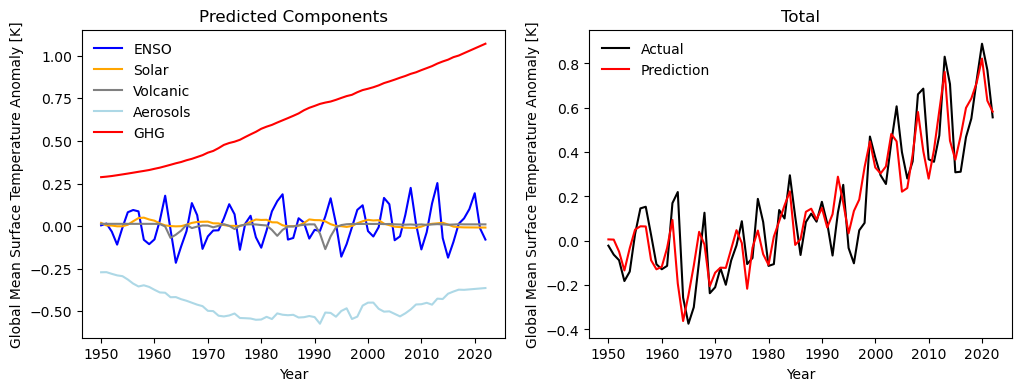

In [11]:
# get the float values for time (for plotting)
time = [t.year for t in Y.time.values]
# define colors (in order of ENSO, solar, volcanic, aerosol, ghg)
cvalues = ['b', 'orange', 'gray', 'lightblue', 'r']

# create the figure
plt.figure(figsize=(12, 4))
# show the components of the prediction
plt.subplot(1, 2, 1)
# The columns of the predictor matrix and the regression coefficients
# are both ordered the same way and correspond to: ENSO, solar, volcanic,
# aerosol, ghg
# We get the contributions from each by simply multiplying: F(t) * beta
for i, key in enumerate(['ENSO', 'Solar', 'Volcanic', 'Aerosols', 'GHG']):
    plt.plot(time, X[:, i] * reg.coef_[i], label=key, color=cvalues[i])
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Year')
plt.ylabel('Global Mean Surface Temperature Anomaly [K]')
plt.title('Predicted Components')

# Now plot the total global mean time series prediction (sum of all components)
plt.subplot(1, 2, 2)
plt.plot(time, Y, 'k', label='Actual')
plt.plot(time, yp, 'r', label='Prediction')
plt.xlabel('Year')
plt.ylabel('Global Mean Surface Temperature Anomaly [K]')
plt.legend(loc='upper left', frameon=False)
plt.title('Total')

### Compare the spread in the estimated forced response across model members

Ideally, our predictions would be perfect and the estimated forced response would match the actual forced response (estimated from the ensemble average time series). Here we look at the spread in our prediction across all model members compared to the spread in the total (forced + unforced) time series and the ensemble average (reference) forced response.

Text(0, 0.5, 'Global Mean Surface Temperature Anomaly [K]')

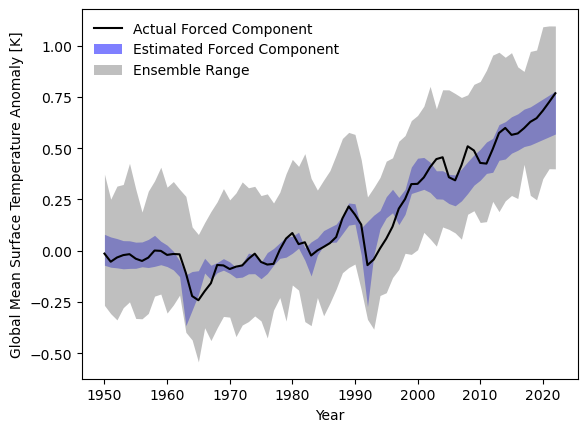

In [12]:
# Lets update and apply this model to predict the forced response for all members
# for each member, we can use the same X matrix (just need to update the ENSO time series, 
# which is specific to each realization)

# create dictionaries to store predictions
predicted_forced_global_mean_timeseries = {model: {}}
predicted_global_mean_timeseries = {model: {}}
# loop over all members to fit regression model
for member in members:
    # get ENSO time series for member
    enso = enso_time_series[model][member]
    # get target global mean time series
    Y = global_mean_timeseries[model][member]
    # only need to update ENSO component of X matrix
    X[:, 0] = enso
    # fit regression model
    reg.fit(X, Y)
    # get total predicted response
    YP = reg.predict(X)
    # get predicted forced response by summing: Solar + Volcanic + Aerosols + GHG
    tsfp = np.sum(X[:, 1:] * reg.coef_[1:], axis=1) + reg.intercept_
    # store in dictionary
    predicted_forced_global_mean_timeseries[model][member] = tsfp
    predicted_global_mean_timeseries[model][member] = YP

# get ensemble mean forced response
tsall = [global_mean_timeseries[model][e] for e in global_mean_timeseries[model].keys()]
tsall = np.array(tsall)
tsf = np.mean(tsall, axis=0)

# get all predictions (in one array)
tsfp = [predicted_forced_global_mean_timeseries[model][e] for e in predicted_forced_global_mean_timeseries[model].keys()]
tsfp = np.array(tsfp)

# plot ensemble mean
plt.plot(time, tsf, 'k', label='Actual Forced Component')
# plot range of predicted forced component (across ensemble)
plt.fill_between(time, np.min(tsfp, axis=0), np.max(tsfp, axis=0), color='b', alpha=0.5, linewidth=0, label='Estimated Forced Component')
# plot total range of anomaly values (forced + unforced across ensemble)
plt.fill_between(time, np.min(tsall, axis=0), np.max(tsall, axis=0), color='gray', alpha=0.5, linewidth=0, label='Ensemble Range')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Year')
plt.ylabel('Global Mean Surface Temperature Anomaly [K]')

### Compute unforced trends (predicted-versus-actual)

We will look at the unforced trends over the satellite-era (1979 - 2022) for the full model ensemble.

In [13]:
# create empty lists for predicted/actual trends
trends_predicted = []
trends_actual = []
# get indices for desired time range
time = np.array(time)
ITIME = np.where((time >= 1979) & (time < 2023))[0]
for member in members:
    # get unforced time series
    tsu = global_mean_timeseries[model][member] - tsf
    # get predicted unforced time series
    tsfp = predicted_forced_global_mean_timeseries[model][member]
    YPU = predicted_global_mean_timeseries[model][member] - tsfp
    # compute linear trends
    mu, b = np.polyfit(time[ITIME], tsu[ITIME], 1)
    mpu, b = np.polyfit(time[ITIME], YPU[ITIME], 1)
    # store trends (in units of per decade)
    trends_predicted.append(mpu*10)
    trends_actual.append(mu*10)

### Plot predicted-versus-actual unforced trends

We predict the predicted-versus-actual unforced global mean trend for each ensemble member (the units are K/decade for temperature). 

Text(-0.04, -0.035, '1 : 1')

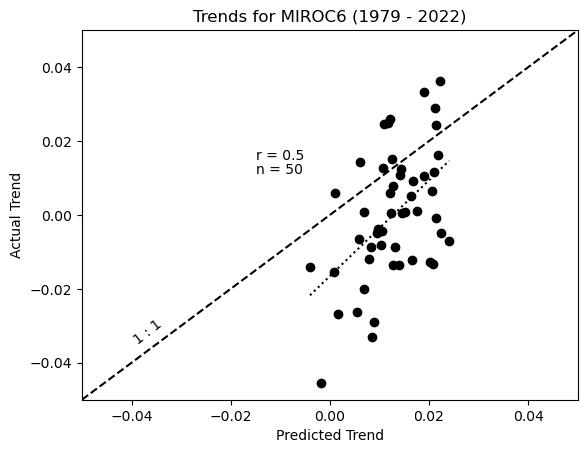

In [14]:
# plot predicted-versus-actual trends
plt.scatter(trends_predicted, trends_actual, color='k')
# best fit line
plt.plot(np.unique(trends_predicted), np.poly1d(np.polyfit(trends_predicted, trends_actual, 1))(np.unique(trends_predicted)), 'k:')
# compute and label correlation and ensemble size
r = np.corrcoef(trends_predicted, trends_actual)[0, 1]
plt.text(-0.015, 0.015, 'r = ' + str(np.round(r, 2)), fontsize=10)
plt.text(-0.015, 0.011, 'n = ' + str(len(members)), fontsize=10)
# axis labels
plt.xlabel('Predicted Trend')
plt.ylabel('Actual Trend')
plt.title('Trends for ' + model + ' (1979 - 2022)')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.plot([-0.05, 0.05], [-0.05, 0.05], 'k--')
plt.text(-0.04, -0.035, '1 : 1', color='k', rotation=38)

### Spatially resolved multiple linear regression

We can also apply multiple linear regression to the full 3D field for spatially resolved predictions – we show this for one ensemble member here. Note that the training data doesn't have missing data – so we haven't accounted for that (though we add functionality to do this later in this notebook).

In [15]:
# only need to update ENSO component of predictor matrix
X[:, 0] = enso_time_series[model][member]

# the predictand time series is now [nt, nlat x nlan]
xmap = np.array(anomaly_maps[model][member])
Y = np.reshape(xmap, (len(time), nlat*nlon))

# fit model
reg.fit(X, Y)

# get predicted time series
yp = reg.predict(X)
# reshape to [nt, lat, lon]
yp = np.reshape(yp, (nt, nlat, nlon))

### Analyze the forced / unforced anomaly maps

Compare the actual-versus-predicted anomaly maps at a few time steps.

In [16]:
# Construct the forced and unforced anomaly maps

# the unforced time series is just ENSO: multiply the ENSO coefficients Beta[lat*lon], by the ENSO index
beta = reg.coef_[:, 0]
enso = X[:, 0]
# need to "expand_dims" so these arrays broadcast together (since beta is size nlat*nlon and enso is size nt)
unforced_anomaly_timeseries = np.expand_dims(enso, axis=1) * np.expand_dims(beta, axis=0)
unforced_anomaly_timeseries = np.reshape(unforced_anomaly_timeseries, (nt, nlat, nlon))

# the forced time series is just: total - unforced
forced_anomaly_timeseries = yp - unforced_anomaly_timeseries

# get the actual, forced anomaly maps
ensemble_mean_timeseries = [anomaly_maps[model][member] for member in anomaly_maps[model].keys()]
ensemble_mean_timeseries = np.mean(np.array(ensemble_mean_timeseries), axis=0)

### Plot forced/unforced anomaly maps for La Niña year

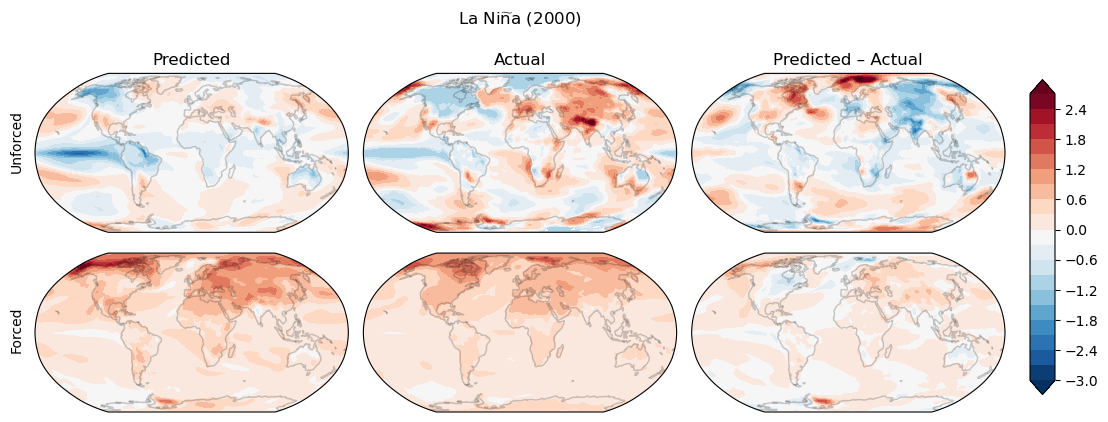

In [17]:
# get a la nina year by finding the largest negative value of our ENSO index
lanina_index = np.where(enso == np.min(enso))[0][0]
# grab lat / lon values for plotting
lat = anomaly_maps[model][member].lat
lon = anomaly_maps[model][member].lon

# plot the following maps: predicted unforced, actual unforced, difference
#                          predicted forced, actual forced, difference
# we do this in a loop so that we repeat less code
map1 = unforced_anomaly_timeseries
map2 = anomaly_maps[model][member] - ensemble_mean_timeseries
map3 = map1 - map2
map4 = forced_anomaly_timeseries
map5 = ensemble_mean_timeseries
map6 = map4 - map5
maps_to_plot = [map1, map2, map3, map4, map5, map6]

# loop over maps and plot
fig = plt.figure(figsize=(10, 4.5))
clevs = np.arange(-3, 3, 0.3)
for i, nmap in enumerate(maps_to_plot):
    plt.subplot(2, 3, i+1, projection=ccrs.Robinson())
    cyclic_data, cyclic_longitude = add_cyclic_point(nmap[lanina_index, :, :], coord=lon)
    # contour map
    im = plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    if i == 0:
        plt.title('Predicted')
    elif i == 1:
        plt.title('Actual')
    elif i == 2:
        plt.title('Predicted – Actual')
# add figure labels
plt.suptitle('La Ni$\mathrm{\widetilde{n}}$a (' + str(time[lanina_index]) + ')')
fig.text(-0.01, 0.625, 'Unforced', rotation=90)
fig.text(-0.01, 0.225, 'Forced', rotation=90)
plt.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.125, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Plot forced/unforced anomaly maps for El Niño year

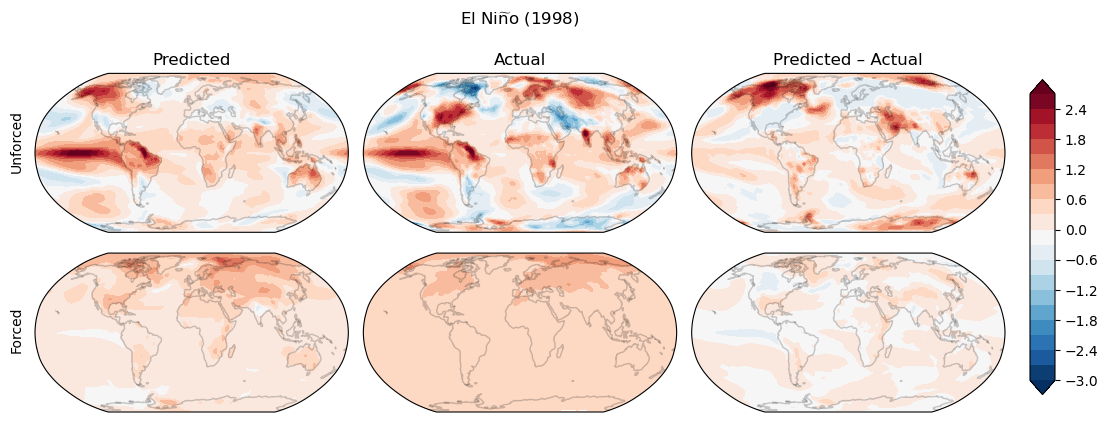

In [18]:
# get an el nino year by finding the largest positive value of our enso index
elnino_index = np.where(enso == np.max(enso))[0][0]

# plot the following maps: predicted unforced, actual unforced, difference
#                          predicted forced, actual forced, difference
# we do this in a loop so that we repeat less code
map1 = unforced_anomaly_timeseries
map2 = anomaly_maps[model][member] - ensemble_mean_timeseries
map3 = map1 - map2
map4 = forced_anomaly_timeseries
map5 = ensemble_mean_timeseries
map6 = map4 - map5
maps_to_plot = [map1, map2, map3, map4, map5, map6]

# loop over maps and plot
fig = plt.figure(figsize=(10, 4.5))
clevs = np.arange(-3, 3, 0.3)
for i, nmap in enumerate(maps_to_plot):
    plt.subplot(2, 3, i+1, projection=ccrs.Robinson())
    cyclic_data, cyclic_longitude = add_cyclic_point(nmap[elnino_index, :, :], coord=lon)
    # contour map
    im = plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    if i == 0:
        plt.title('Predicted')
    elif i == 1:
        plt.title('Actual')
    elif i == 2:
        plt.title('Predicted – Actual')
# add figure labels
plt.suptitle('El Ni$\mathrm{\widetilde{n}}$o (' + str(time[elnino_index]) + ')')
fig.text(-0.01, 0.625, 'Unforced', rotation=90)
fig.text(-0.01, 0.225, 'Forced', rotation=90)
plt.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.125, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Plot the Coefficient Maps

These maps tell us how strongly each predictor projects onto each spatial point.

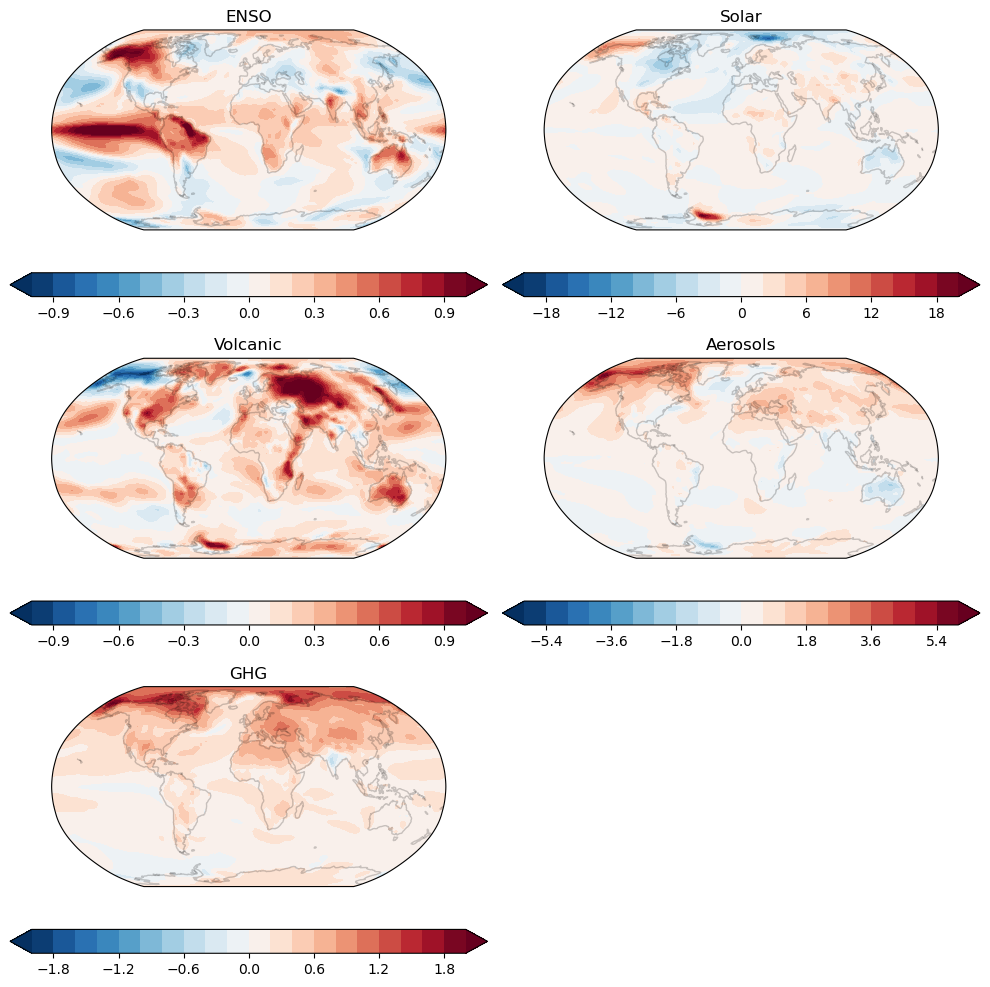

In [19]:
# transform beta maps into [predictor, lat, lon]
beta = np.reshape(reg.coef_, (72, 144, 5))
beta = np.transpose(beta, (2, 0, 1))

# create figure
plt.figure(figsize=(10, 10))
# loop over predictors
for i, key in enumerate(['ENSO', 'Solar', 'Volcanic', 'Aerosols', 'GHG']):
    # create map subplot
    plt.subplot(3, 2, i+1, projection=ccrs.Robinson())
    # get max absolute value to create equal divering colorbar
    max_color = np.floor(np.max(np.abs(beta[i, :, :])))
    clevs = np.linspace(-max_color, max_color, 21)
    # deal with prime meridian plotting issue
    cyclic_data, cyclic_longitude = add_cyclic_point(beta[i, :, :], coord=lon)
    # contour map
    plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(key)
    # colorbar
    plt.colorbar(orientation='horizontal')
plt.tight_layout()

### Combine steps into a function

This function takes the steps from above to create a function that fits our multiple linear regression model. In it, we add some functionality to handle missing data. 

In [20]:
def get_mlr_prediction(ts_target, ts_enso, predictor_data):
    """
    get_mlr_prediction(ts_target, ts_enso, predictor_data)
    
    Function takes a target time series (either ts_target[time]
    or ts_target[time, lat, lon]), a predictor enso time series,
    ts_enso[time], and a predictor_data dictionary (containing
    time series for solar, volcanic, aerosols, and ghg forcing).
    The function returns a dictionary containing the contributions
    of each forcing term to the time series.
    
    Inputs:
    -------
    ts_target, array: Array containing target data of form
                         [time] or [time, lat, lon]
    ts_enso, array: Array containing 1D ENSO predictor time series
    predictor_data, Dict: Dict containing forcing predictor time
                          series.
    
    Returns:
    -------
    ts_predict, Dict: Dict containing the keys total, ENSO,
                      Solar, Volcanic, Aerosols, and GHG,
                      representing their contribution to the
                      time series (either ts[time] or 
                      ts[time, lat, lon]).
    """
    # create empty output dictionary
    ts_predict = {}
    # create predictor matrix
    nt = ts_target.shape[0]
    X = np.zeros((nt, 5))
    X[:, 0] = ts_enso
    X[:, 1] = predictor_data['solar']
    X[:, 2] = predictor_data['volcanic']
    X[:, 3] = predictor_data['aerosols']
    X[:, 4] = predictor_data['ghg']
    # create predictand matrix
    # if 3D, reshape to [nt, nlat*nlon]
    if len(ts_target.shape) > 1:
        ts_target = np.reshape(np.array(ts_target), (nt, -1))
        Y = ts_target
        flag_3d = True
    else:
        Y = ts_target
        flag_3d = False
    # handle missing data
    if flag_3d:
        Y_DATA = np.where(~np.isnan(Y[0, :]))[0]  # indices where valid data exists
        if len(Y_DATA) > 0:
            flag_missing = True
            Y = Y[:, Y_DATA]
        else:
            flag_missing = False
    # initialize linear model and fit
    reg = LinearRegression()
    reg.fit(X, Y)
    # get total predicted time series
    yp = reg.predict(X)
    # if 3d, reshape to [time, lat, lon]
    if flag_3d:
        # handle missing data
        if flag_missing:
            ytemp = np.zeros((nt, nlat*nlon)) * np.nan
            ytemp[:, Y_DATA] = yp
            yp = ytemp
        yp = np.reshape(yp, (nt, nlat, nlon))
    ts_predict['total'] = yp
    # get predicted time series related to each forcing
    for i, key in enumerate(['ENSO', 'Solar', 'Volcanic', 'Aerosols', 'GHG']):
        if flag_3d:
            beta = reg.coef_[:, i]
            yy = np.expand_dims(beta, axis=0) * np.expand_dims(X[:, i], axis=1)
            # handle missing data
            if flag_missing:
                ytemp = np.zeros((nt, nlat*nlon)) * np.nan
                ytemp[:, Y_DATA] = yy
                yy = ytemp
            yy = np.reshape(yy, (nt, nlat, nlon))
        else:
            beta = reg.coef_[i]
            yy = beta * X[:, i]
        # store predicted component
        ts_predict[key] = yy
    return ts_predict

### Loop over training models and apply multiple linear regression

Here we use our `load_realization` and `get_mlr_prediction` to load and fit data from all of the training models and realizations. We store the predicted forced and unforced flobal mean time series, the actual (total) global mean time series, the predicted forced trend maps over the user-specified training/validation period, and the actual (total) trend maps over the user-specified time period.

In [21]:
# get all models in training dataset
model_dirs = glob.glob(root_dir + 'Training/' + cmipTable[ncvar] + '/' + cmipVar[ncvar] + '/*')
models = [p.split('/')[-1] for p in model_dirs]

# initialize dictionaries to store output data
predicted_unforced_global_mean_timeseries = {}
global_mean_timeseries = {}
predicted_trend_maps = {}
actual_trend_maps = {}

# loop over models
for im, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    predicted_forced_global_mean_timeseries[model] = {}
    predicted_unforced_global_mean_timeseries[model] = {}
    global_mean_timeseries[model] = {}
    predicted_trend_maps[model] = {}
    actual_trend_maps[model] = {}
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    for member in members:
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data
        ts_3d, ts_gm, ts_enso = load_realization(fn, vid, tv_time_period, reference_period)
        # fit 1D regression model
        p = get_mlr_prediction(ts_gm, ts_enso, predictor_data)
        # get predicted forced time series (total minus enso)
        ts_gmp = p['total'] - p['ENSO']
        # store data
        predicted_forced_global_mean_timeseries[model][member] = ts_gmp
        predicted_unforced_global_mean_timeseries[model][member] = p['ENSO']
        global_mean_timeseries[model][member] = ts_gm
        # fit 3d regression model
        p = get_mlr_prediction(ts_3d, ts_enso, predictor_data)
        # get predicted forced trend map (total minus enso)
        ts = p['total'] - p['ENSO']
        # reshape to do linear fit (for predicted trend)
        ts = np.reshape(ts, (nt, nlat*nlon))
        tmap, b = np.polyfit(time, ts, 1)
        tmap *= 10  # to K/decade units
        tmap = np.reshape(tmap, (nlat, nlon))
        # store predicted forced trend
        predicted_trend_maps[model][member] = tmap
        # get actual trend map
        ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
        tmap, b = np.polyfit(time, ts_3d, 1)
        tmap *= 10  # to K/decade units
        tmap = np.reshape(tmap, (nlat, nlon))
        actual_trend_maps[model][member] = tmap
        # update progress
        print(".", end="")
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 57.91420388221741 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 52.43184518814087 seconds

3 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 62.41266226768494 seconds

4 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 104.37409591674805 seconds

5 / 5: CESM2 (50 members)
..................................................
Time elapsed: 92.60891461372375 seconds



### Plot predicted time series' for each model

Plot the predicted-versus-actual forced/unforced components of the series for the training data. For the unforced time series, we simply use the first member as an example.

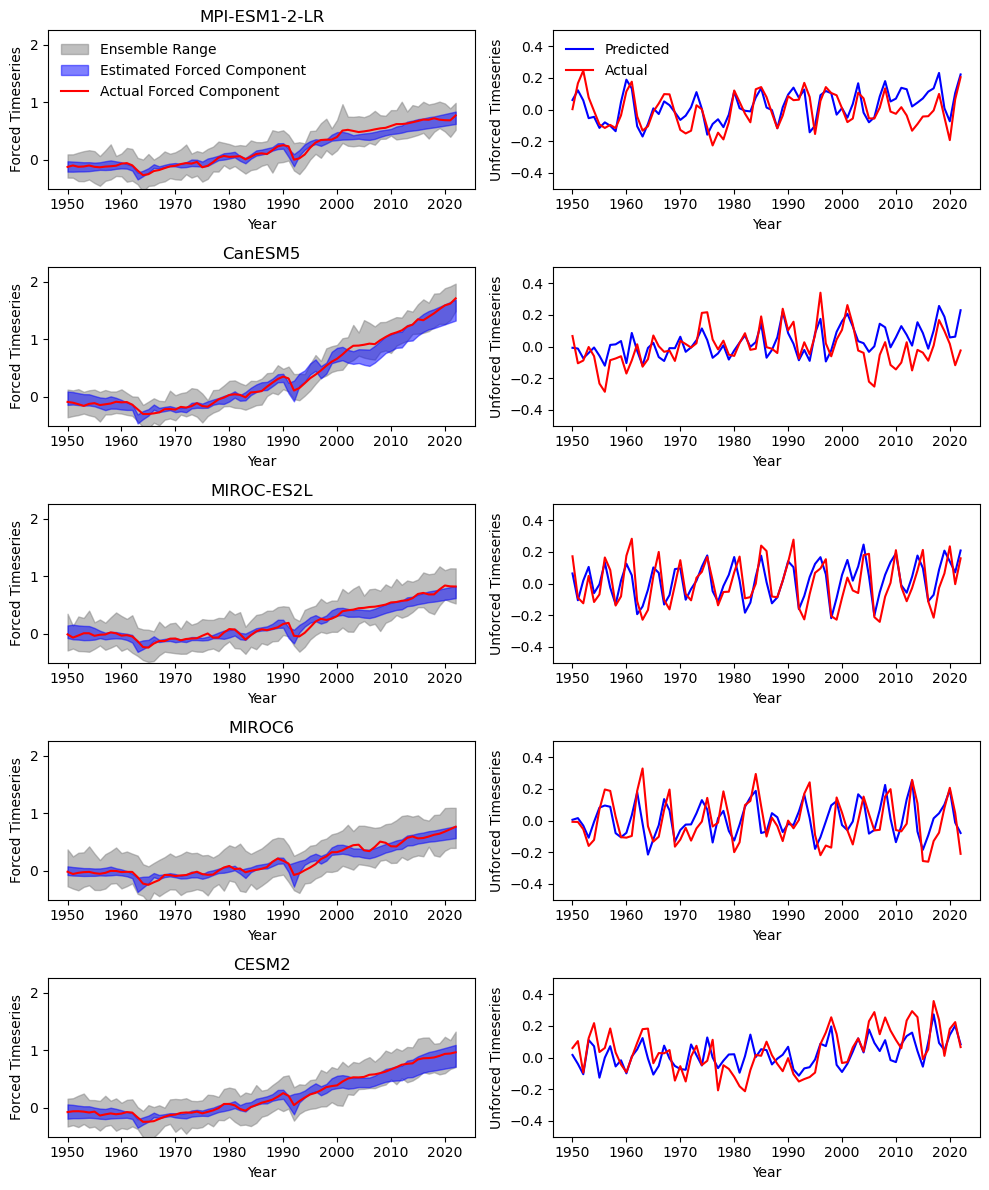

In [22]:
# create figure
plt.figure(figsize=(10, 12))
for im, model in enumerate(models):
    # get model members
    members = list(predicted_forced_global_mean_timeseries[model].keys())
    # get all time series
    ypfall = [predicted_forced_global_mean_timeseries[model][member] for member in members]
    ypfall = np.array(ypfall)
    yall = [global_mean_timeseries[model][member] for member in members]
    # get ensemble average
    yall = np.array(yall)
    yf = np.mean(yall, axis=0)
    # get unforced timeseries (for example member)
    ypu = predicted_unforced_global_mean_timeseries[model][members[0]]
    yu = global_mean_timeseries[model][members[0]] - yf
    # plot forced time series [left panels]
    plt.subplot(len(models), 2, im*2+1)
    # full range
    plt.fill_between(time, np.min(yall, axis=0), np.max(yall, axis=0), color='gray', alpha=0.5, label='Ensemble Range')
    # forced predicted range
    plt.fill_between(time, np.min(ypfall, axis=0), np.max(ypfall, axis=0), color='b', alpha=0.5, label='Estimated Forced Component')
    # actual forced
    plt.plot(time, yf, 'r', label='Actual Forced Component')
    # labels
    plt.title(model)
    plt.xlabel('Year')
    plt.ylabel('Forced Timeseries')
    plt.ylim(-0.5, 2.25)
    if im == 0:
        plt.legend(loc='upper left', frameon=False)
    # plot unforced time series [right panels]
    plt.subplot(len(models), 2, im*2+2)
    # unforced prediction example
    plt.plot(time, ypu, color='b', label='Predicted')
    # actual unforced
    plt.plot(time, yu, 'r', label='Actual')
    plt.ylabel('Unforced Timeseries')
    plt.xlabel('Year')
    plt.ylim(-0.5, 0.5)
    if im == 0:
        plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

### Plot the predicted-versus-actual forced trend maps

Here we plot the ensemble mean average as the forced map and compare it to the predicted forced trend map (predicted using data from the first ensemble member from each model).

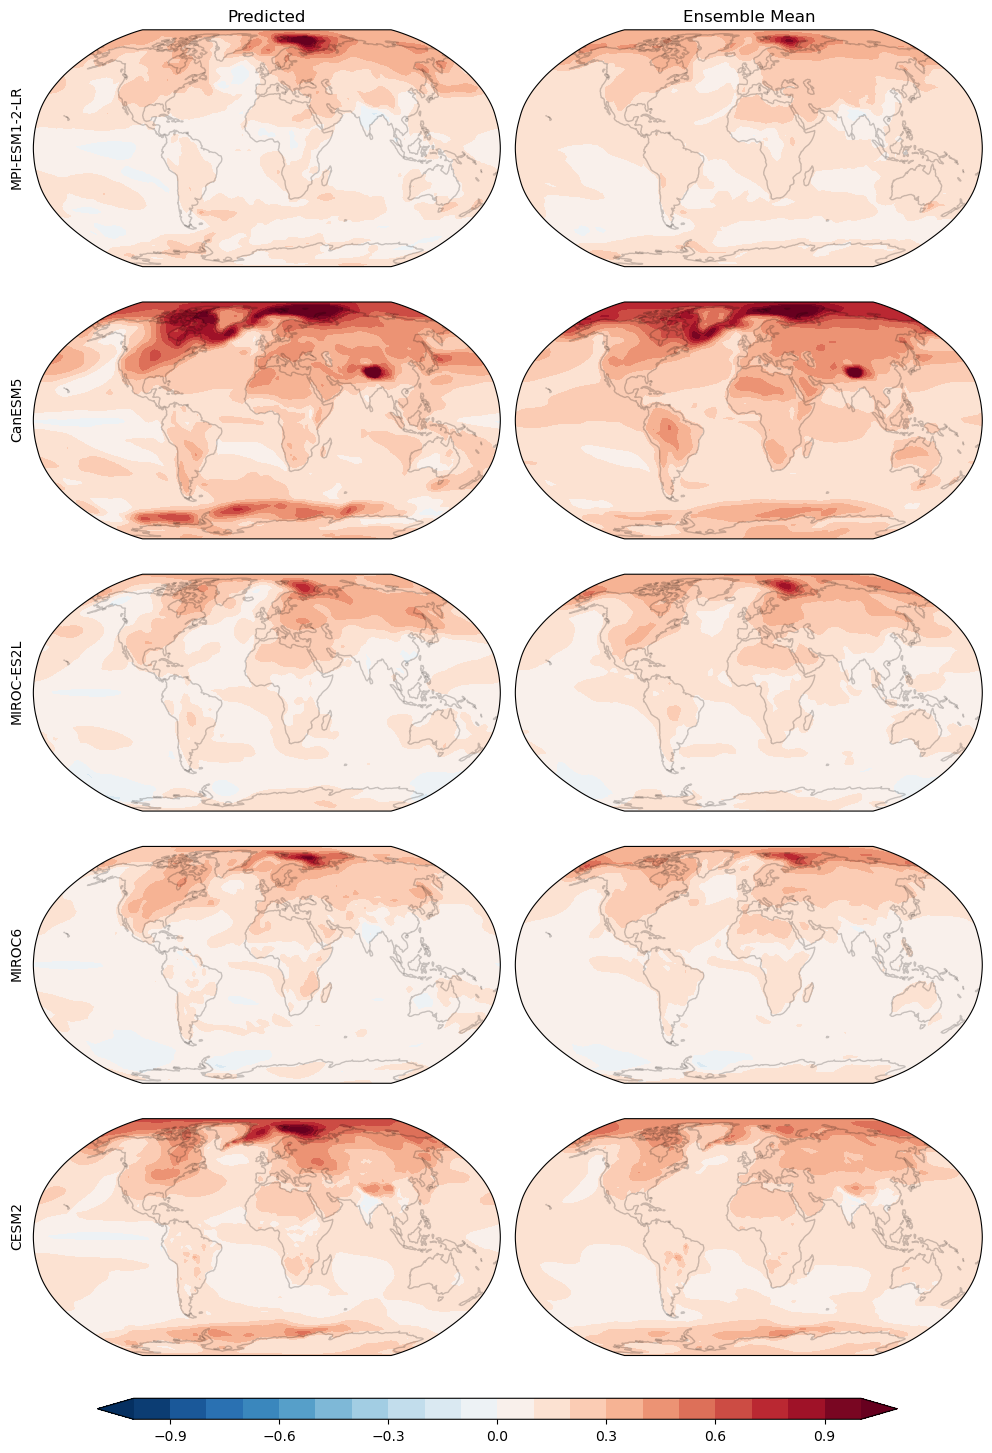

In [23]:
fig = plt.figure(figsize=(10, 14))
for im, model in enumerate(predicted_trend_maps.keys()):
    # get first member
    members = list(predicted_trend_maps[model].keys())
    member1 = members[0]
    tmap = predicted_trend_maps[model][member1]
    # get ensemble mean actual forced trend
    atmap = [actual_trend_maps[model][member] for member in members]
    atmap = np.mean(np.array(atmap), axis=0)
    # create predicted map subplot
    plt.subplot(5, 2, im*2+1, projection=ccrs.Robinson())
    clevs = np.linspace(-1, 1, 21)
    # deal with prime meridian plotting issue
    cyclic_data, cyclic_longitude = add_cyclic_point(tmap, coord=lon)
    # contour map
    plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    # labels
    if im == 0:
        plt.title('Predicted')
    plt.gca().text(-0.02, 0.55, model, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=plt.gca().transAxes)
    # create actual map subplot
    plt.subplot(5, 2, im*2+2, projection=ccrs.Robinson())
    # deal with prime meridian plotting issue
    cyclic_data, cyclic_longitude = add_cyclic_point(atmap, coord=lon)
    # contour map
    icm = plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    if im == 0:
        plt.title('Ensemble Mean')
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.025, 0.8, 0.015])
fig.colorbar(icm, cax=cbar_ax, orientation='horizontal')

### Produce forced estimates for evaluation data

Now we apply multiple linear regression to the evaluation data.

In [24]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionaries to store evaluation data output
evaluation_model_predictions = {}
evaluation_model_3d_predictions = {}

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # load data
    ts_3d, ts_gm, ts_enso = load_realization(fn, vid, tv_time_period, reference_period)
    # fit regression model (1D)
    p = get_mlr_prediction(ts_gm, ts_enso, predictor_data)
    evaluation_model_predictions[model] = p
    # fit regression model (3D)
    p = get_mlr_prediction(ts_3d, ts_enso, predictor_data)
    evaluation_model_3d_predictions[model] = p

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J


### Plot the predicted forced trend for each evaluation model

This trend map is over the full time period (in K/decade).

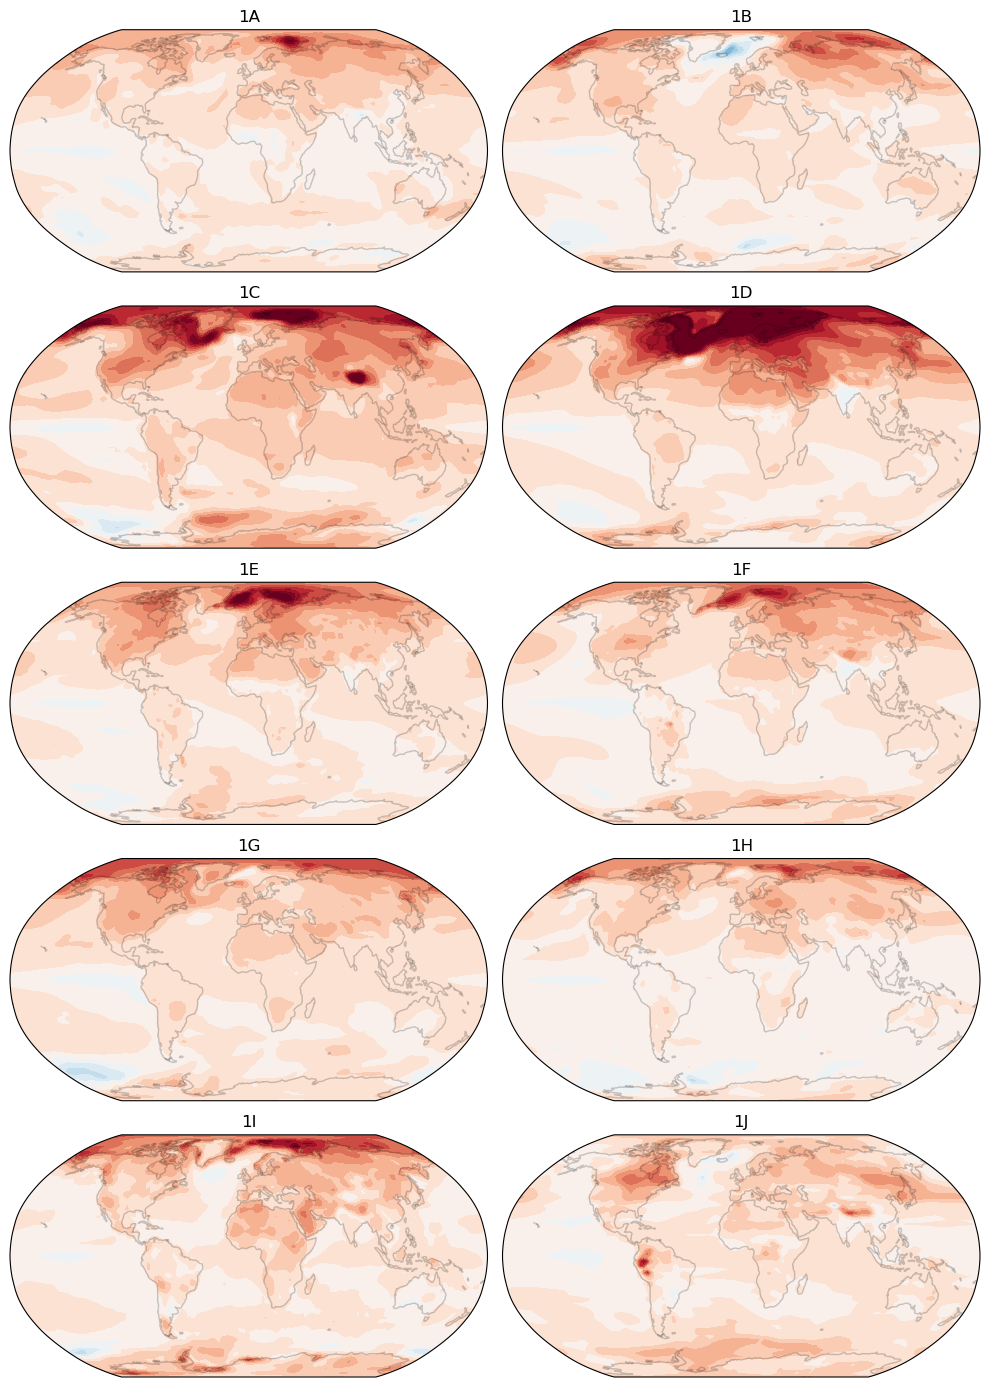

In [25]:
plt.figure(figsize=(10, 14))
for im, model in enumerate(evaluation_model_3d_predictions.keys()):
    # the forced component is everything but ENSO
    tst = evaluation_model_3d_predictions[model]['total']
    tse = evaluation_model_3d_predictions[model]['ENSO']
    ts = tst - tse
    # reshape to do linear fit 
    ts = np.reshape(ts, (nt, nlat*nlon))
    tmap, b = np.polyfit(time, ts, 1)
    tmap *= 10  # to K/decade units
    tmap = np.reshape(tmap, (nlat, nlon))
    # create map subplot
    plt.subplot(5, 2, im+1, projection=ccrs.Robinson())
    clevs = np.linspace(-1, 1, 21)
    # deal with prime meridian plotting issue
    cyclic_data, cyclic_longitude = add_cyclic_point(tmap, coord=lon)
    # contour map
    plt.contourf(cyclic_longitude, lat, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(model)
plt.tight_layout()

### Discussion Questions

* Why do you think the coefficient maps look the way they do?
* We used the Ni$\mathrm{\widetilde{n}}$o 3.4 index as our index for internal variability. Can you think of a better index? Do you think this is sufficient for representing internal variability?
* Do you think the forcing time series are a good predictor? What is a drawback of using forcing as a predictor?
* The ForceSMIP protocol asks for spatially resolved predictions of the forced response (e.g., [`time`, `lat`, `lon`]) on *monthly* timescales. How could you extend this notebook to go from annual predictions to monthly predictions?
* Do you think this approach would work well for other variables of interest?
* How would you improve this method?